In [952]:
import os, joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import CraneDataset
from utils.detect_roll_over import detect_roll_over

In [953]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

In [954]:
dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()

feature_names = dataset_inst.get_data_feature_names()
target_names = dataset_inst.get_data_target_names()

for t_name in target_names:
    raw_dataset[t_name] = raw_dataset[t_name]/1000

# for t_name in target_names:
#     raw_dataset = raw_dataset[raw_dataset[t_name]>=0]
    
raw_dataset = raw_dataset[raw_dataset['Time(sec)']>5]

raw_dataset.reset_index(drop=True, inplace=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [955]:
left_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Left_3(N)', 'Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)']
right_load_name_list = ['Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)', 'Actual_Load_Right_3(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

front_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)']
rear_load_name_list = ['Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

In [991]:
for i in range(22):
    data_sample = raw_dataset[raw_dataset['file_idx']==i]

In [992]:
data_sample = raw_dataset[raw_dataset['file_idx']==11]
time_arr = data_sample['Time(sec)'].to_numpy()
angle_arr = data_sample['Swing_Angle(deg)'].to_numpy()

In [993]:
angle_list_1 = [0, 45, 90, 135, 180, 225, 270, 315, 360]
left_ref_load_list = [0.50, 0.70, 0.80, 0.70, 0.50, 0.30, 0.20, 0.30, 0.50]
right_ref_load_list = [0.50, 0.30, 0.20, 0.30, 0.50, 0.70, 0.80, 0.70, 0.50]

angle_list_2 = [0, 45, 90, 135, 180, 225, 270, 315, 360]
front_ref_load_list = [0.6, 0.9, 1.0, 0.9, 0.6, 0.9, 1.0, 0.9, 0.6]

In [994]:
ref_angle_arr = np.linspace(0, 360, 36001)

ref_left_load_ratio_2 = 0.5*np.sin(np.deg2rad(ref_angle_arr))+0.5
ref_left_load_ratio_2 = (0.6*ref_left_load_ratio_2)+0.2

ref_right_load_ratio_2 = 1 - ref_left_load_ratio_2

ref_front_load_ratio = 0.3 * np.sin(np.radians(ref_angle_arr) + np.pi / 2) + 0.5
ref_rear_load_ratio = 1 - ref_front_load_ratio

ref_left_load_ratio = np.interp(ref_angle_arr, angle_list_1, left_ref_load_list)
ref_right_load_ratio = np.interp(ref_angle_arr, angle_list_1, right_ref_load_list)

<Axes: >

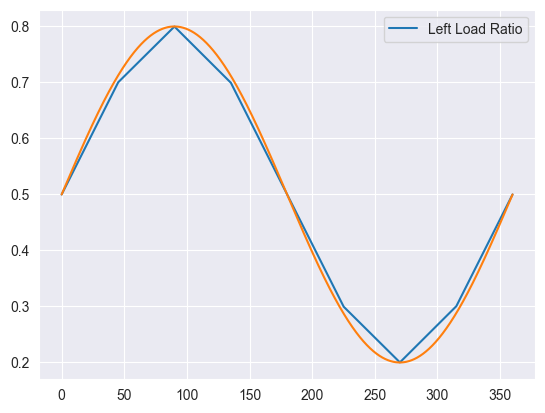

In [995]:
sns.lineplot(x=ref_angle_arr, y=ref_left_load_ratio, label='Left Load Ratio')
sns.lineplot(x=ref_angle_arr, y=ref_left_load_ratio_2)

<Axes: >

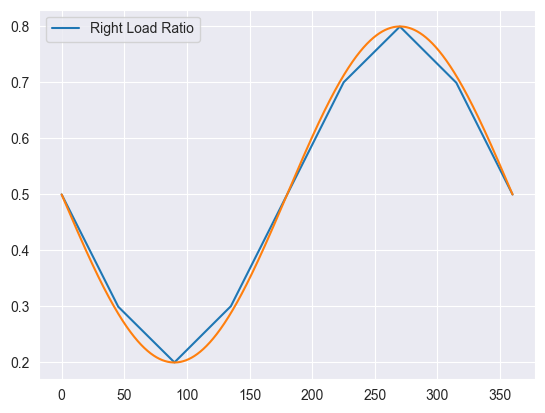

In [996]:
sns.lineplot(x=ref_angle_arr, y=ref_right_load_ratio, label='Right Load Ratio')
sns.lineplot(x=ref_angle_arr, y=ref_right_load_ratio_2)

<Axes: >

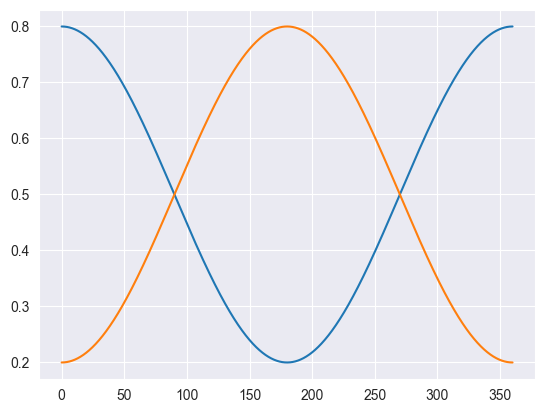

In [997]:
sns.lineplot(x=ref_angle_arr, y=ref_front_load_ratio)
sns.lineplot(x=ref_angle_arr, y=ref_rear_load_ratio)

In [998]:
data_sample['safe_state'].iloc[0]

1.0

In [999]:
left_load_margin_list = []
right_load_margin_list = []
front_load_margin_list = []
rear_load_margin_list = []

for i in range(data_sample.shape[0]):
    sample = data_sample.iloc[i, :]
    load = sample[left_load_name_list+right_load_name_list].to_numpy()
    swing_angle = sample['Swing_Angle(deg)']
    
    left_load_margin, right_load_margin, front_load_margin, rear_load_margin = detect_roll_over(load, swing_angle)
    
    left_load_margin_list.append(left_load_margin)
    right_load_margin_list.append(right_load_margin)
    front_load_margin_list.append(front_load_margin)
    rear_load_margin_list.append(rear_load_margin)

(0.0, 2.0)

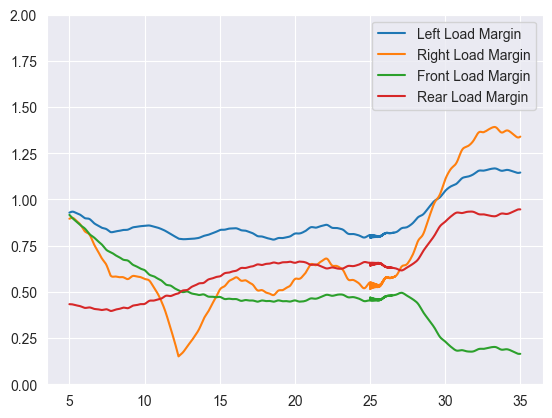

In [1000]:
sns.lineplot(x=time_arr, y=left_load_margin_list, label='Left Load Margin')
sns.lineplot(x=time_arr, y=right_load_margin_list, label='Right Load Margin')
sns.lineplot(x=time_arr, y=front_load_margin_list, label='Front Load Margin')
sns.lineplot(x=time_arr, y=rear_load_margin_list, label='Rear Load Margin')

plt.ylim(0, 2)

<Axes: ylabel='Roll_Angle(deg)'>

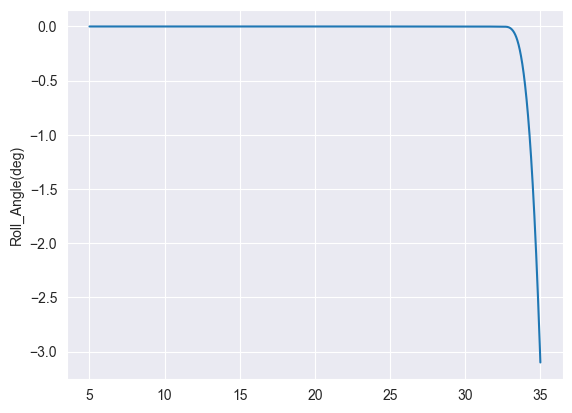

In [1001]:
sns.lineplot(x=time_arr, y=data_sample['Roll_Angle(deg)'])

<Axes: ylabel='Pitch_Angle(deg)'>

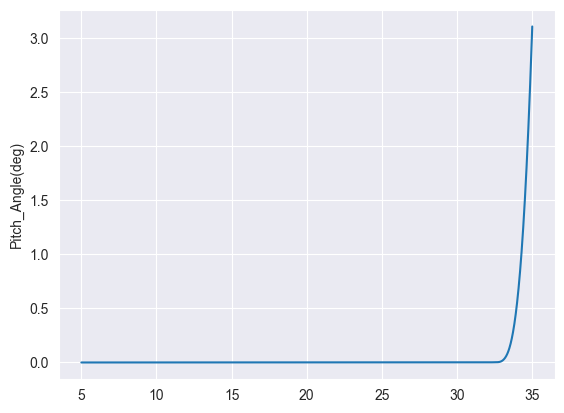

In [1002]:
sns.lineplot(x=time_arr, y=data_sample['Pitch_Angle(deg)'])

In [1003]:
side_load_total_list = []
left_load_total_list = []
right_load_total_list = []

for i in range(data_sample.shape[0]):
    data_row = data_sample.iloc[i, :]
    
    side_load_total_list.append(data_row[left_load_name_list+right_load_name_list].sum())
    left_load_total_list.append(data_row[left_load_name_list].sum())
    right_load_total_list.append(data_row[right_load_name_list].sum())

side_load_total_list = np.array(side_load_total_list)
left_load_total_list = np.array(left_load_total_list)
right_load_total_list = np.array(right_load_total_list)

<Axes: >

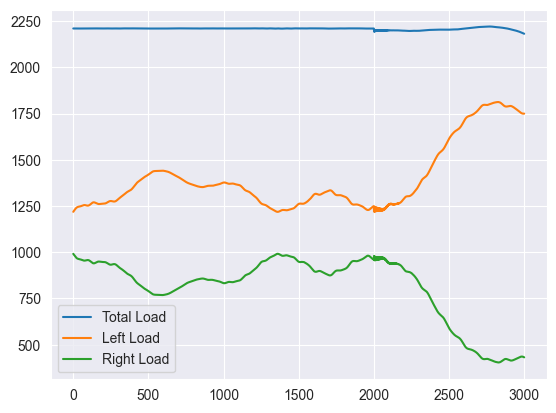

In [1004]:
sns.lineplot(side_load_total_list, label='Total Load')
sns.lineplot(left_load_total_list, label='Left Load')
sns.lineplot(right_load_total_list, label='Right Load')

#plt.ylim(0, 2000)

In [1005]:
front_view_total_list = []
front_load_total_list = []
rear_load_total_list = []

for i in range(data_sample.shape[0]):
    data_row = data_sample.iloc[i, :]
    load = data_row[front_load_name_list+rear_load_name_list].to_numpy()
    
    front_view_total_list.append(np.sum(load))
    front_load_total_list.append(np.sum(data_row[front_load_name_list]))
    rear_load_total_list.append(np.sum(data_row[rear_load_name_list]))

front_view_total_list = np.array(front_view_total_list)
front_load_total_list = np.array(front_load_total_list)
rear_load_total_list = np.array(rear_load_total_list)

<Axes: >

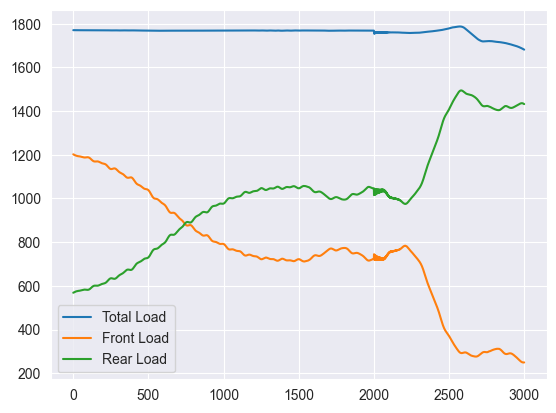

In [1006]:
sns.lineplot(front_view_total_list, label='Total Load')
sns.lineplot(front_load_total_list, label='Front Load')
sns.lineplot(rear_load_total_list, label='Rear Load')

<Axes: >

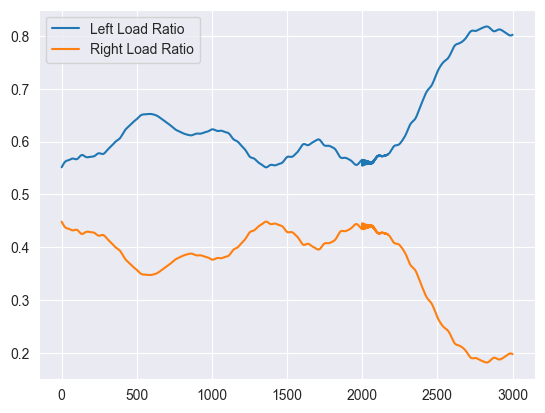

In [1007]:
left_load_ratio = (left_load_total_list/side_load_total_list)
right_load_ratio = (right_load_total_list/side_load_total_list)

sns.lineplot(left_load_ratio, label='Left Load Ratio')
sns.lineplot(right_load_ratio, label='Right Load Ratio')

<Axes: >

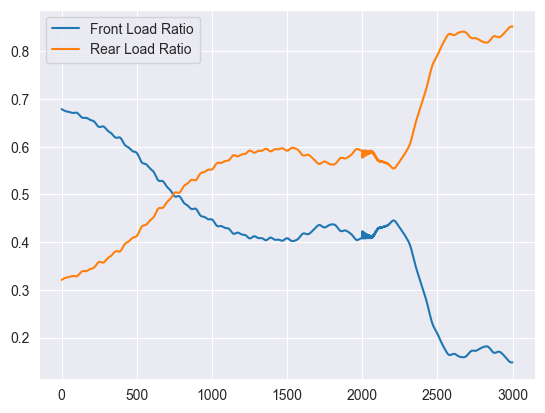

In [1008]:
front_load_ratio = (front_load_total_list/front_view_total_list)
rear_load_ratio = (rear_load_total_list/front_view_total_list)

sns.lineplot(front_load_ratio, label='Front Load Ratio')
sns.lineplot(rear_load_ratio, label='Rear Load Ratio')

<Axes: >

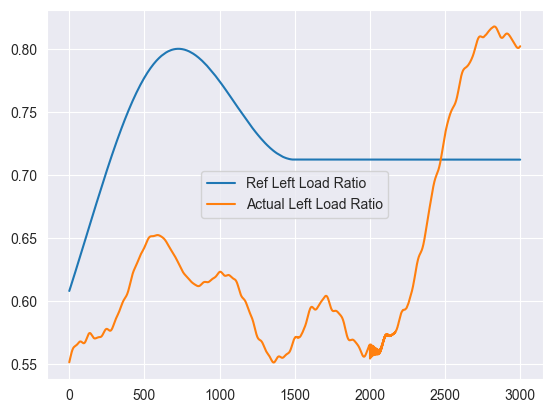

In [1009]:
ref_left_load_ratio_list = []

for i in range(data_sample.shape[0]):
    sample = data_sample.iloc[i, :]
    swing_angle = sample['Swing_Angle(deg)']
    
    idx = np.argmin(np.abs(ref_angle_arr - swing_angle))
    ref_left_load_ratio_list.append(ref_left_load_ratio_2[idx])
    
sns.lineplot(ref_left_load_ratio_list, label='Ref Left Load Ratio')
sns.lineplot(left_load_ratio, label='Actual Left Load Ratio')

<Axes: >

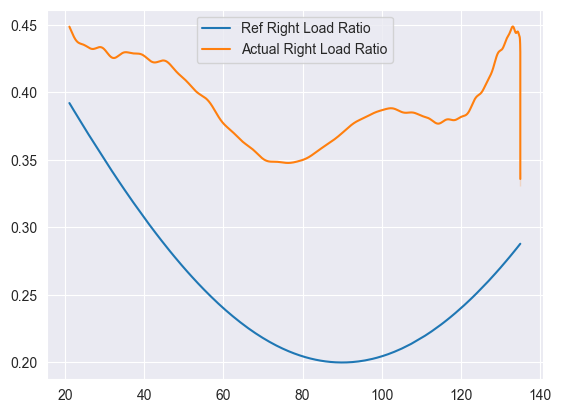

In [1010]:
ref_right_load_ratio_list = []

for i in range(data_sample.shape[0]):
    sample = data_sample.iloc[i, :]
    swing_angle = sample['Swing_Angle(deg)']
    
    idx = np.argmin(np.abs(ref_angle_arr - swing_angle))
    ref_right_load_ratio_list.append(ref_right_load_ratio_2[idx])

sns.lineplot(x=angle_arr, y=ref_right_load_ratio_list, label='Ref Right Load Ratio')
sns.lineplot(x=angle_arr, y=right_load_ratio, label='Actual Right Load Ratio')

<Axes: >

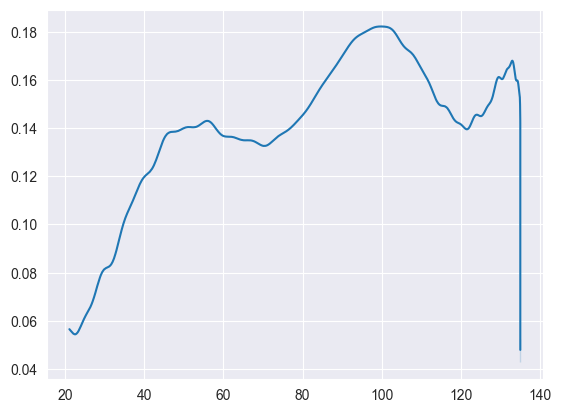

In [1011]:
left_margin = (ref_left_load_ratio_list-left_load_ratio)
sns.lineplot(x=angle_arr, y=left_margin)

<Axes: >

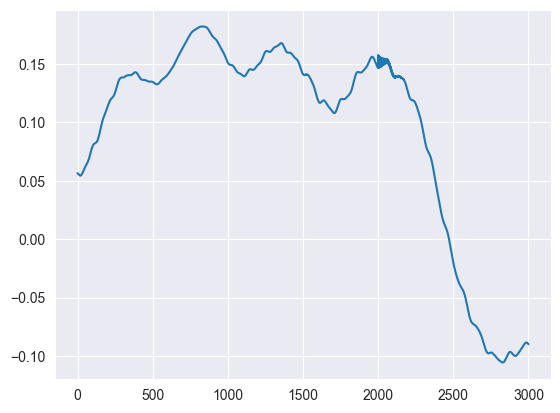

In [1012]:
right_margin = (right_load_ratio-ref_right_load_ratio_list)
sns.lineplot(right_margin)

<Axes: >

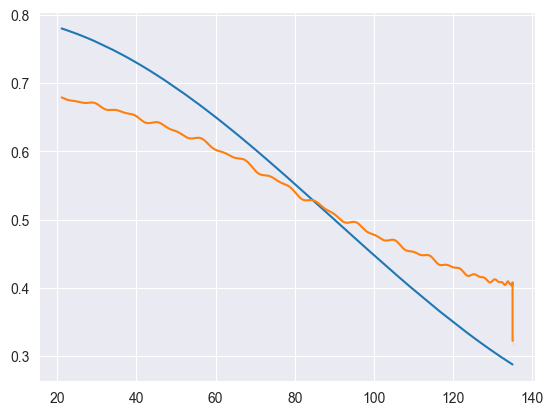

In [1013]:
ref_front_load_ratio_list = []

for i in range(data_sample.shape[0]):
    sample = data_sample.iloc[i, :]
    swing_angle = sample['Swing_Angle(deg)']
    
    idx = np.argmin(np.abs(ref_angle_arr - swing_angle))
    ref_front_load_ratio_list.append(ref_front_load_ratio[idx])
    
sns.lineplot(x=angle_arr, y=ref_front_load_ratio_list)
sns.lineplot(x=angle_arr, y=front_load_ratio)

<Axes: >

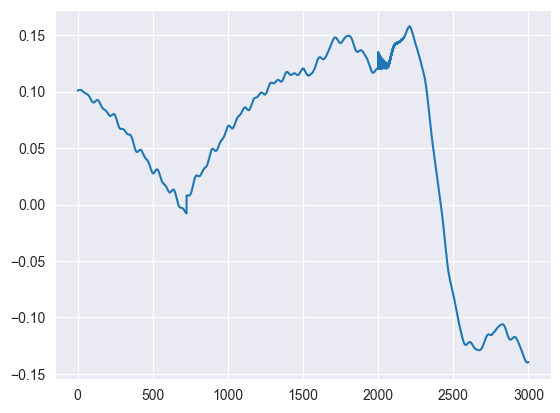

In [1014]:
margin_list = []

for ref_ratio, actual_ratio in zip(ref_front_load_ratio_list, front_load_ratio):
    if ref_ratio > 0.5:
        margin = ref_ratio - actual_ratio
    else:
        margin = actual_ratio - ref_ratio
    
    margin_list.append(margin)

sns.lineplot(margin_list)

<Axes: >

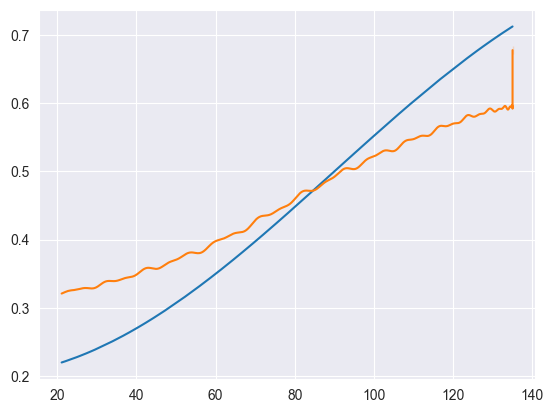

In [1015]:
ref_rear_load_ratio_list = []

for i in range(data_sample.shape[0]):
    sample = data_sample.iloc[i, :]
    swing_angle = sample['Swing_Angle(deg)']
    
    idx = np.argmin(np.abs(ref_angle_arr - swing_angle))
    ref_rear_load_ratio_list.append(ref_rear_load_ratio[idx])
    
sns.lineplot(x=angle_arr, y=ref_rear_load_ratio_list)
sns.lineplot(x=angle_arr, y=rear_load_ratio)

<Axes: >

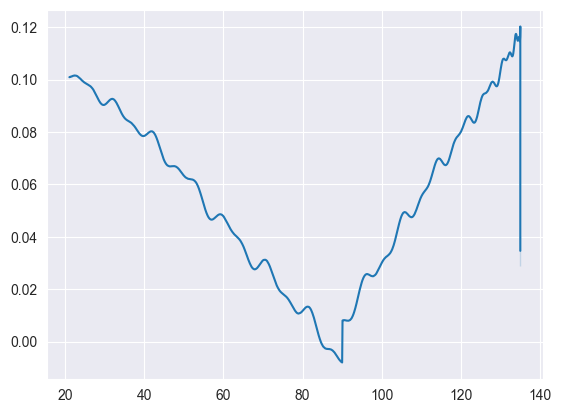

In [1016]:
margin_list = []

for ref_ratio, actual_ratio in zip(ref_rear_load_ratio_list, rear_load_ratio):
    if ref_ratio > 0.5:
        margin = ref_ratio - actual_ratio
    else:
        margin = actual_ratio - ref_ratio
    
    margin_list.append(margin)

sns.lineplot(x=angle_arr, y=margin_list)

In [1017]:
margin_arr = np.zeros(4)
load_ratio_arr = np.zeros(4)

def calculate_margin(ref_left_ratio, ref_right_ratio, ref_front_ratio, ref_rear_ratio, ground_load, swing_angle_i):    
    global margin_arr, load_ratio_arr
    
    left_load_idx_list = [0, 1, 2, 3, 4]
    right_load_idx_list = [5, 6, 7, 8, 9]

    front_load_idx_list = [0, 1, 5, 6]
    rear_load_idx_list = [3, 4, 8, 9]
    
    load_total = np.sum(ground_load)
    left_load_total = np.sum(ground_load[left_load_idx_list])
    right_load_total = np.sum(ground_load[right_load_idx_list])
    
    front_view_load_total = np.sum(ground_load[front_load_idx_list+rear_load_idx_list])
    front_load_total = np.sum(ground_load[front_load_idx_list])
    rear_load_total = np.sum(ground_load[rear_load_idx_list])

    load_ratio_arr[0] = (left_load_total / load_total)
    load_ratio_arr[1] = (right_load_total / load_total)
    load_ratio_arr[2] = (front_load_total / front_view_load_total)
    load_ratio_arr[3] = (rear_load_total / front_view_load_total)
    
    angle_idx = np.argmin(np.abs(ref_angle_arr - swing_angle_i))
    
    if 0 <= swing_angle_i < 180:
        margin_arr[0] = ref_left_ratio[angle_idx] - load_ratio_arr[0]
        margin_arr[1] = load_ratio_arr[1] - ref_right_ratio[angle_idx]

    if 180 <= swing_angle_i < 360:
        margin_arr[0] = load_ratio_arr[0] - ref_left_ratio[angle_idx]
        margin_arr[1] = ref_right_ratio[angle_idx] - load_ratio_arr[1]

    if 0 <= swing_angle_i < 90 or 270 <= swing_angle_i < 360:
        margin_arr[2] = ref_front_ratio[angle_idx] - load_ratio_arr[2]
        margin_arr[3] = load_ratio_arr[3] - ref_rear_ratio[angle_idx]

    if 90 <= swing_angle_i < 270:
        margin_arr[2] = load_ratio_arr[2] - ref_front_ratio[angle_idx]
        margin_arr[3] = ref_rear_ratio[angle_idx] - load_ratio_arr[3] 
    
    return margin_arr


left_margin_list = []
right_margin_list = []
front_margin_list = []
rear_margin_list = []
detection_result_list = []

for i in range(data_sample.shape[0]):
    sample = data_sample.iloc[i, :]
    load_arr = sample[left_load_name_list+right_load_name_list].to_numpy()
    swing_angle = sample['Swing_Angle(deg)']
    
    margin_arr_output = calculate_margin(ref_left_load_ratio_2, ref_right_load_ratio_2, ref_front_load_ratio, ref_rear_load_ratio, load_arr, swing_angle)
    
    left_margin_list.append(margin_arr_output[0])
    right_margin_list.append(margin_arr_output[1])
    front_margin_list.append(margin_arr_output[2])
    rear_margin_list.append(margin_arr_output[3])
    
    detection_result_list.append(int(np.any(margin_arr_output <= -0.05)))

<Axes: >

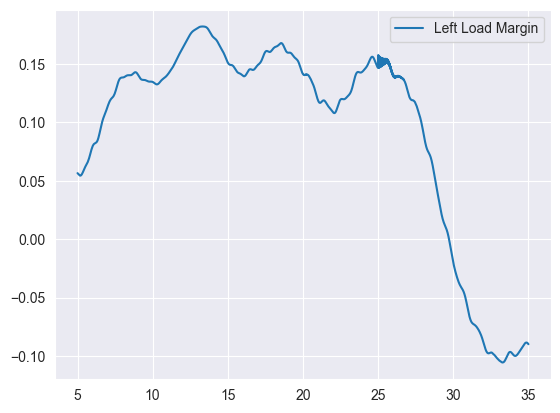

In [1018]:
sns.lineplot(x=time_arr, y=np.array(left_margin_list), label='Left Load Margin')

<Axes: >

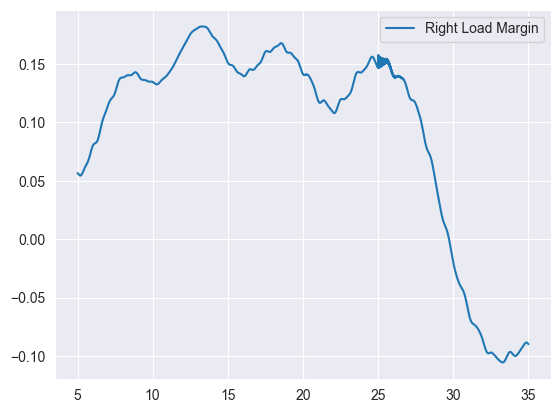

In [1019]:
sns.lineplot(x=time_arr, y=np.array(right_margin_list), label='Right Load Margin')

<Axes: >

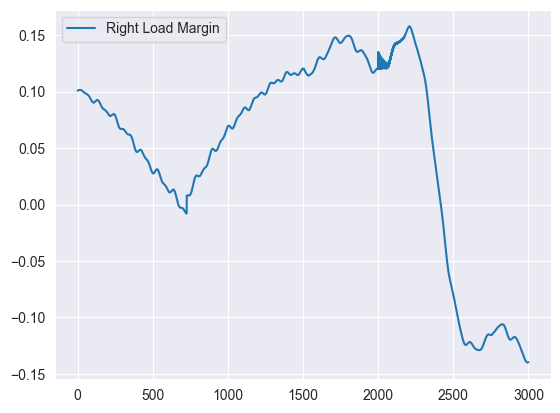

In [1020]:
sns.lineplot(front_margin_list, label='Right Load Margin')
#sns.lineplot(rear_margin_list, label='Rear Load Margin')

<Axes: >

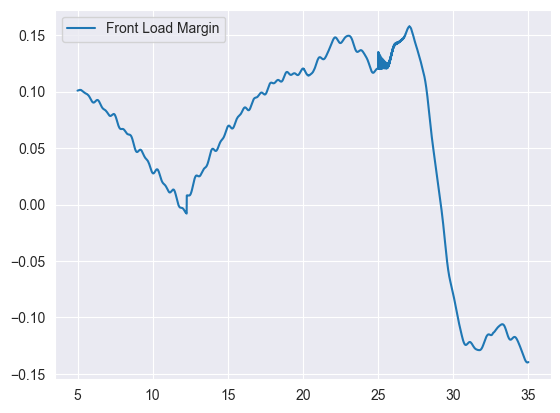

In [1021]:
sns.lineplot(x=time_arr, y=rear_margin_list, label='Front Load Margin')

<Axes: ylabel='Actual_Load_Left_1(N)'>

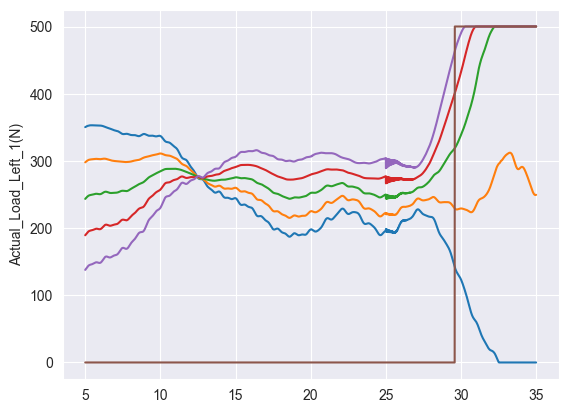

In [1022]:
for i in range(5):
    sns.lineplot(x=time_arr, y=data_sample[left_load_name_list[i]])

sns.lineplot(x=time_arr, y=np.array(detection_result_list)*500)

<Axes: ylabel='Actual_Load_Right_1(N)'>

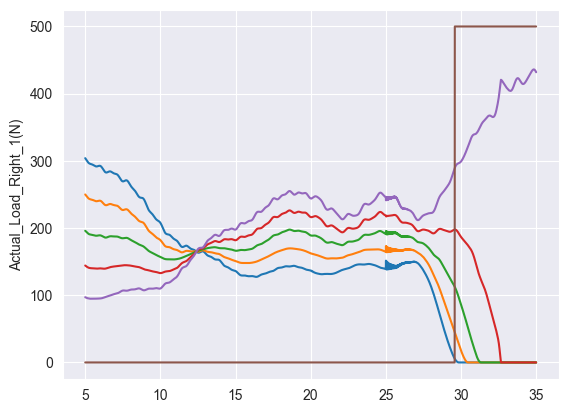

In [1023]:
for i in range(5):
    sns.lineplot(x=time_arr, y=data_sample[right_load_name_list[i]])

sns.lineplot(x=time_arr, y=np.array(detection_result_list)*500)

<Axes: ylabel='Pitch_Angle(deg)'>

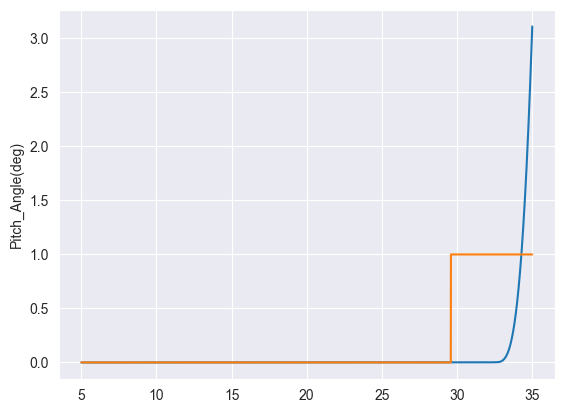

In [1024]:
sns.lineplot(x=time_arr, y=data_sample['Pitch_Angle(deg)'])
sns.lineplot(x=time_arr, y=np.array(detection_result_list))

<Axes: ylabel='Roll_Angle(deg)'>

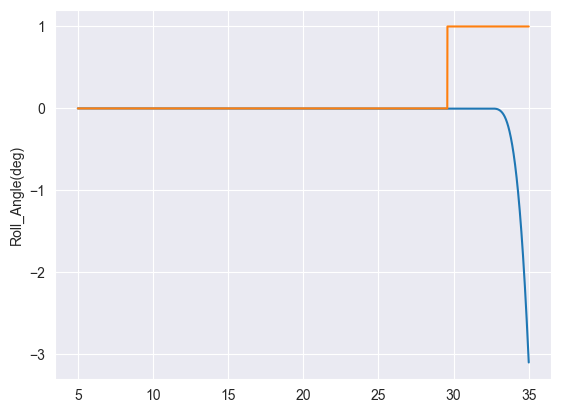

In [1025]:
sns.lineplot(x=time_arr, y=data_sample['Roll_Angle(deg)'])
sns.lineplot(x=time_arr, y=np.array(detection_result_list))